In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow import keras

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/ResearchWork_2023/Single_disease/train_images.zip'
!unzip '/content/drive/MyDrive/ResearchWork_2023/Single_disease/test_images.zip'
!unzip '/content/drive/MyDrive/ResearchWork_2023/Single_disease/val_images.zip'

In [ ]:

# Load the pre-trained Inception-ResNet-V2 model
base_model = tf.keras.applications.vgg19.VGG19(weights='imagenet', include_top=False, input_shape=(299,299,3))

# Freeze the pre-trained weights
base_model.trainable = False

# Pass the input layer through the pre-trained model
features = base_model.output

outputs = tf.keras.layers.Flatten()(features)
outputs = tf.keras.layers.Dense(units=8, activation='softmax')(outputs)

80134624/80134624 [==============================] - 1s 0us/step


In [ ]:
# !pip install tensorflow_addons
# import tensorflow_addons as tfa
accuracy = tf.keras.metrics.Accuracy()
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()
# f1_score = tfa.metrics.F1Score(num_classes=8)
categorical_accuracy = tf.keras.metrics.CategoricalAccuracy()

In [ ]:

# Create the model
model = tf.keras.Model(inputs=base_model.input, outputs=outputs)
# Compile the model
# base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
               loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[categorical_accuracy, precision , recall])

In [ ]:
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 299, 299, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 299, 299, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 149, 149, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 149, 149, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 149, 149, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 74, 74, 128)       0     

In [ ]:

# Load the image data and one-hot encoded multi-label data
# Load the data from the excel sheet into a pandas dataframe
# Load both left and right eye dataset
base_path = '/content/drive/MyDrive/ResearchWork_2023/Single_disease'
train_df = pd.read_excel(f'{base_path}/train_labels.xlsx')
test_df = pd.read_excel(f'{base_path}/test_labels.xlsx')
val_df = pd.read_excel(f'{base_path}/val_labels.xlsx')


/usr/local/lib/python3.9/dist-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [ ]:
train_df

,Unnamed: 0.2,Unnamed: 0,Unnamed: 0.1,Fundus,Diagnostic_Keywords,N,D,G,C,A,H,M,O
0,0,0,0,0_left.jpg,cataract,0,0,0,1,0,0,0,0
1,1,1,1,1_left.jpg,normal fundus,1,0,0,0,0,0,0,0
2,3,3,3,3_left.jpg,normal fundus,1,0,0,0,0,0,0,0
3,4,4,4,4_left.jpg,macular epiretinal membrane,0,0,0,0,0,0,0,1
4,5,5,5,5_left.jpg,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6455,6953,3477,3494,4683_right.jpg,mild nonproliferative retinopathy,0,1,0,0,0,0,0,0
6456,6954,3478,3495,4686_right.jpg,proliferative diabetic retinopathy,0,1,0,0,0,0,0,0
6457,6955,3479,3496,4688_right.jpg,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0
6458,6956,3480,3497,4689_right.jpg,normal fundus,1,0,0,0,0,0,0,0


# Train

In [ ]:
labels = train_df.iloc[:, 3:].values

In [ ]:
# labels

In [ ]:
# Split the data into two arrays, one for the image paths and one for the labels
train_images_base_path = '/content/train_cropped_images/'
image_paths = train_images_base_path + train_df["Fundus"].values
labels = train_df.iloc[:, 5:].values

# Convert the lists to tensors
image_paths = tf.constant(image_paths)
labels = tf.constant(labels)

# Create a dataset from the image paths and labels
train_dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))

# Test

In [ ]:

# Split the data into two arrays, one for the image paths and one for the labels
test_images_base_path = '/content/test_cropped_images/'
image_paths = test_images_base_path + test_df["Fundus"].values
labels = test_df.iloc[:, 5:].values

# Convert the lists to tensors
image_paths = tf.constant(image_paths)
labels = tf.constant(labels)

# Create a dataset from the image paths and labels
test_dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))

# Validation

In [ ]:
# Split the data into two arrays, one for the image paths and one for the labels
val_images_base_path = '/content/val_cropped_images/'
image_paths = val_images_base_path + val_df["Fundus"].values
labels = val_df.iloc[:, 5:].values

# Convert the lists to tensors
image_paths = tf.constant(image_paths)
labels = tf.constant(labels)

# Create a dataset from the image paths and labels
val_dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))

In [ ]:
# Load the images and preprocess them
def load_and_preprocess_image(file_path, label):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [299, 299])
    image = tf.keras.applications.vgg19.preprocess_input(image)
    return image, label

# Apply the load_and_preprocess_image function to the dataset
train_dataset = train_dataset.map(load_and_preprocess_image)
test_dataset = test_dataset.map(load_and_preprocess_image)
val_dataset = val_dataset.map(load_and_preprocess_image)

# Shuffle the data and batch it
batch_size = 32
train_dataset = train_dataset.shuffle(buffer_size=len(image_paths)).batch(batch_size)
test_dataset = test_dataset.shuffle(buffer_size=len(image_paths)).batch(batch_size)
val_dataset = val_dataset.shuffle(buffer_size=len(image_paths)).batch(batch_size)

In [ ]:
train_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 8), dtype=tf.int64, name=None))>

In [ ]:
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 8), dtype=tf.int64, name=None))>

In [ ]:
val_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 8), dtype=tf.int64, name=None))>

In [ ]:
# Train the model
history=model.fit(train_dataset, epochs=20, batch_size=batch_size, validation_data=val_dataset)

Epoch 1/20
202/202 [==============================] - 144s 564ms/step - loss: 3.5467 - categorical_accuracy: 0.4760 - precision: 0.4815 - recall: 0.4670 - val_loss: 4.9656 - val_categorical_accuracy: 0.3418 - val_precision: 0.3405 - val_recall: 0.3344
Epoch 2/20
202/202 [==============================] - 112s 501ms/step - loss: 1.9056 - categorical_accuracy: 0.6034 - precision: 0.6131 - recall: 0.5954 - val_loss: 5.0751 - val_categorical_accuracy: 0.3291 - val_precision: 0.3333 - val_recall: 0.3217
Epoch 3/20
202/202 [==============================] - 114s 512ms/step - loss: 1.1311 - categorical_accuracy: 0.7067 - precision: 0.7181 - recall: 0.6960 - val_loss: 4.1216 - val_categorical_accuracy: 0.4299 - val_precision: 0.4344 - val_recall: 0.4214
Epoch 4/20
202/202 [==============================] - 111s 507ms/step - loss: 0.6880 - categorical_accuracy: 0.7902 - precision: 0.7996 - recall: 0.7779 - val_loss: 4.2981 - val_categorical_accuracy: 0.4268 - val_precision: 0.4295 - val_recall:

In [ ]:
model.save('/content/drive/MyDrive/ResearchWork_2023/models/model_vgg19_s.h5')

In [ ]:
import matplotlib.pyplot as plt

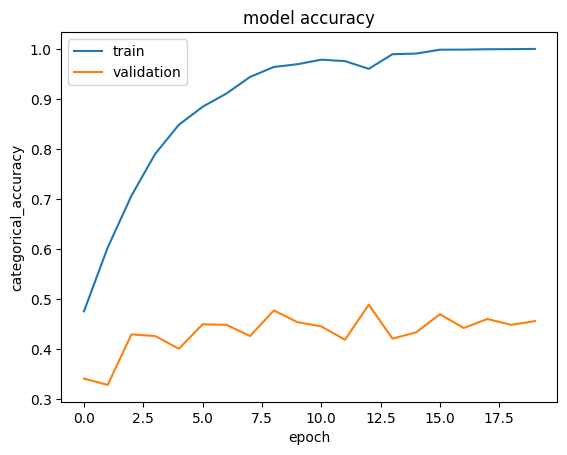

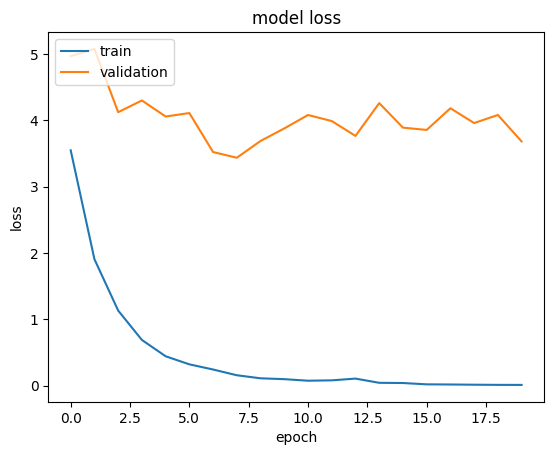

In [ ]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
result = model.evaluate(test_dataset)
result

60/60 [==============================] - 35s 408ms/step - loss: 3.9276 - categorical_accuracy: 0.4483 - precision: 0.4526 - recall: 0.4409


[3.927586793899536, 0.4482576549053192, 0.4525745213031769, 0.4408659040927887]

In [ ]:
# load_model = tf.keras.saving.load_model('/content/drive/MyDrive/ResearchWork_2023/models/model_4.h5',compile=False)

In [ ]:
import numpy as np

# Assuming you have a test dataset 'test_data' with image tensors and corresponding labels
predictions = []
true_labels = []

# Iterate over the test dataset and make predictions
for images, labels in test_dataset:
    preds = model.predict(images)
    predictions.extend(np.argmax(preds, axis=1))
    true_labels.extend(np.argmax(labels, axis=1))

# Compute the confusion matrix
cm = tf.math.confusion_matrix(true_labels, predictions)

# Convert the confusion matrix to a NumPy array and print it
print("Confusion Matrix:")
print(cm.numpy())


1/1 [==============================] - 0s 205ms/step
Confusion Matrix:
[[576 166   8   3   7   2   0  57]
 [ 87  68   2   0   2   3   0  16]
 [ 43   5  12   0   0   0   0   5]
 [ 12   2   1  62   0   0   0   4]
 [ 34  10   1   1   6   0   3  15]
 [ 14   9   0   0   0   1   0   3]
 [  9   1   0   3   1   0  42   2]
 [269 146   9  11  16   1  62  82]]
